In [9]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline # for plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
# data_path = 'data/financial_data/USD_INR.csv'
data_path = 'data/bike_data/hour.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# Showing the data file csv or comma separated value
data[:10]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


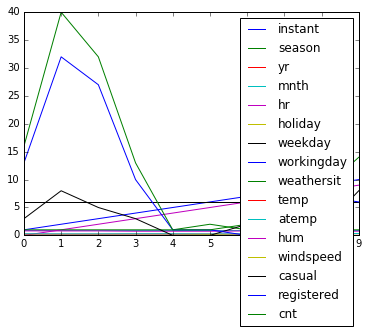

In [10]:
# # Plotting the smartwatch data before scaling/batch normalization
# data[:10000]['Price'].plot()
data[: 10].plot()
plt.legend()
plt.show()

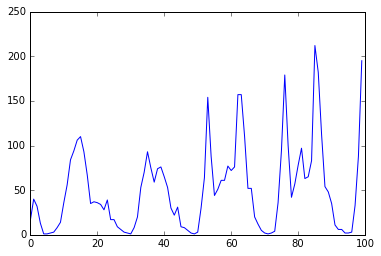

In [11]:
data_array = np.array(data)
data_array.shape, data_array.dtype
data_main = np.array(data_array[:, -1:], dtype=float)
data_main.shape, data_main.dtype

plt.plot(data_main[:100])
plt.show()

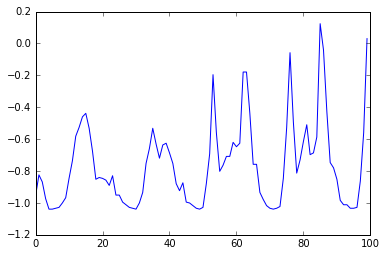

(-1.0548364452851478e-16, 1.0, 1.0, (17379, 1), dtype('float64'))

In [12]:
mean = np.mean(data_main, axis=0)
std = np.std(data_main, axis=0)
std.shape, mean.shape, std.dtype, mean.dtype

data_norm = (data_main - mean) / std
plt.plot(data_norm[:100])
plt.show()
data_norm.mean(), data_norm.std(), data_norm.var(), data_norm.shape, data_norm.dtype

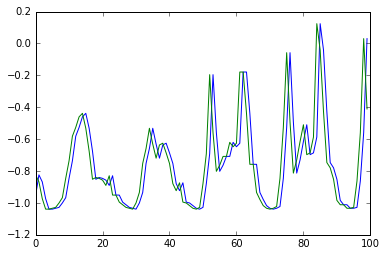

In [13]:
train_data = data_norm[:16000] # the last dim/variable/feature
test_data = data_norm[16000:] # the last dim/variable/feature
train_data.shape, test_data.shape
X_train = train_data[0:15999]
Y_train = train_data[1:16000]
X_train.shape, Y_train.shape

plt.plot(X_train[:100])
plt.plot(Y_train[:100])
plt.show()

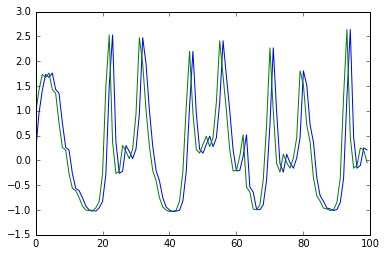

In [14]:
X_valid = test_data[0:1378] 
Y_valid = test_data[1:1379]
X_valid.shape, Y_valid.shape
plt.plot(X_valid[:100])
plt.plot(Y_valid[:100])
plt.show()

In [15]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H):
        self.D = D
        self.H = H
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        low_Z, high_Z = (-1. / np.sqrt(Z / 2.)), (1. / np.sqrt(Z / 2.))
        low_H, high_H = (-1. / np.sqrt(H / 2.)), (1. / np.sqrt(H / 2.))
        # low, high = (-1.0), (+1.0)
        # low, high = (-0.5), (+0.5)
        m = dict(
            # Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            # Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            # Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            # Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            Wz=np.random.uniform(size=(Z, H), low=low_Z, high=high_Z),
            Wr=np.random.uniform(size=(Z, H), low=low_Z, high=high_Z),
            Wh=np.random.uniform(size=(Z, H), low=low_Z, high=high_Z),
            Wy=np.random.uniform(size=(H, D), low=low_H, high=high_H),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = m
        
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, 
                 y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, fc_caches = [], []

        for X in X_train:
            X = X.reshape(1, -1) # X_1xn
            y, h, fc_cache = self.forward(X, h, self.model)
            fc_caches.append(fc_cache)
            ys.append(y)
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        caches = fc_caches
        
        return ys, caches
                                
    def loss_function(self, y_pred, y_train):
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression(y_pred=y, y_train=Y)
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        fc_caches = caches
        
        dh = np.zeros((1, self.H)) 
        grad = {key: np.zeros_like(val) for key, val in self.model.items()}
        grads= {key: np.zeros_like(val) for key, val in self.model.items()}

        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dX, dh, grad = self.backward(dy, dh, fc_caches[t])
            for key in grad.keys():
                grads[key] += grad[key]
                
        return dX, grads # TODO: dX is not used but this is a REMINDER that it exists!
    
    def test(self, X_seed, h, size):
        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            y, h, _ = self.forward(X, h, self.model)
            X = y.copy() # previous out for the next input for prediction
            ys.append(y) # list array
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        return ys

In [16]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:(i + minibatch_size)]
        y_mini = y[i:(i + minibatch_size)]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, XY_valid, alpha, mb_size, n_iter, print_after):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid

    # Momentum
    M= {key: np.zeros_like(val) for key, val in nn.model.items()}
    R= {key: np.zeros_like(val) for key, val in nn.model.items()}
    
    # Learning decay: suggested by Justin Jhonson in Standford
    beta1 = .9
    beta2 = .99
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    # Epochs: iterating through the whole data
    for iter in range(1, n_iter + 1):
        
        # Minibatches
        for idx in range(len(minibatches)):
            
            # Train the model
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini) #, alpha=alpha
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Update the model
            for key in grads.keys(): #key, value: items
                M[key] = l.exp_running_avg(M[key], grads[key], beta1)
                R[key] = l.exp_running_avg(R[key], grads[key]**2, beta2)
                m_k_hat = M[key] / (1. - (beta1** iter))
                r_k_hat = R[key] / (1. - (beta2** iter))
                nn.model[key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the model (by testing)
            ys = nn.test(X_seed=X_valid[0], h=state, size=X_valid.shape[0]) # ys_tx1xn
            valid_loss, _ = nn.loss_function(y_pred=ys, y_train=Y_valid) #, alpha=alpha
            nn.losses['valid'].append(valid_loss)

        # Print the model loss/ error
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.8f}, valid loss: {:.8f}'.format(iter, loss, valid_loss))

    return nn

In [17]:
# Hyper-parameters
time_step = 128 # minibatch size: 32, 64, 128, or 256 Cache
n_iter = 200 # epochs
alpha = 1e-4 # learning_rate: 1e-3, 5e-4, 1e-4 - default choices
print_after = 1 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = X_train.shape[1] # X_txn: noise given by using all possible channels/ features

# Build the network and learning it or optimizing it using SGD
# def adam_rnn(nn, X_train, y_train, alpha=0.001, mb_size=256, n_iter=2000, print_after=100):
net = GRU(D=num_input_units, H=num_hidden_units) 

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=(X_train, Y_train), XY_valid=(X_valid, Y_valid), alpha=alpha, mb_size=time_step,
         n_iter=n_iter, print_after=print_after)

Iter-1, train loss: 43.47683044, valid loss: 632.84644934
Iter-2, train loss: 39.61085030, valid loss: 632.62086813
Iter-3, train loss: 36.80123505, valid loss: 632.66455489
Iter-4, train loss: 34.62201390, valid loss: 632.89639025
Iter-5, train loss: 32.92987360, valid loss: 633.36451991
Iter-6, train loss: 31.54376765, valid loss: 634.15680111
Iter-7, train loss: 30.33311595, valid loss: 635.26678925
Iter-8, train loss: 29.23601853, valid loss: 636.62953474
Iter-9, train loss: 28.21959077, valid loss: 638.17891785
Iter-10, train loss: 27.26036659, valid loss: 639.88850355
Iter-11, train loss: 26.33781994, valid loss: 641.79848739
Iter-12, train loss: 25.43003501, valid loss: 644.05192775
Iter-13, train loss: 24.50806627, valid loss: 647.04639789
Iter-14, train loss: 23.52529755, valid loss: 651.87507723
Iter-15, train loss: 22.39440902, valid loss: 662.11165900
Iter-16, train loss: 20.96139126, valid loss: 695.24171210
Iter-17, train loss: 19.31658189, valid loss: 816.54085276
Iter-1

Iter-139, train loss: 4.12839319, valid loss: 1915.32570429
Iter-140, train loss: 4.13372450, valid loss: 2054.06098315
Iter-141, train loss: 4.13884379, valid loss: 2250.24088678
Iter-142, train loss: 4.14374428, valid loss: 1845.33497981
Iter-143, train loss: 4.14842034, valid loss: 2235.61599885
Iter-144, train loss: 4.15286774, valid loss: 2241.55162875
Iter-145, train loss: 4.15708371, valid loss: 2235.80835361
Iter-146, train loss: 4.16106710, valid loss: 2201.98121363
Iter-147, train loss: 4.16481842, valid loss: 2230.73942156
Iter-148, train loss: 4.16833986, valid loss: 2239.39836785
Iter-149, train loss: 4.17163522, valid loss: 2240.93966906
Iter-150, train loss: 4.17470985, valid loss: 2209.59729562
Iter-151, train loss: 4.17757050, valid loss: 2267.64589623
Iter-152, train loss: 4.18022506, valid loss: 2280.46413132
Iter-153, train loss: 4.18268242, valid loss: 2288.61629074
Iter-154, train loss: 4.18495210, valid loss: 2289.13194186
Iter-155, train loss: 4.18704406, valid 

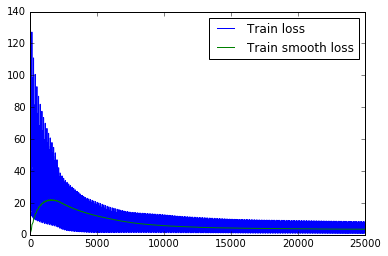

In [18]:
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

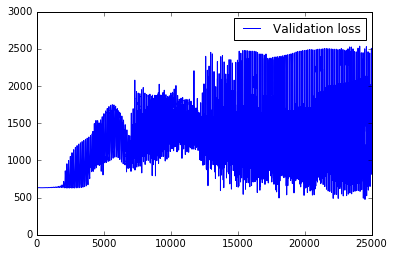

In [19]:
import matplotlib.pyplot as plt

plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

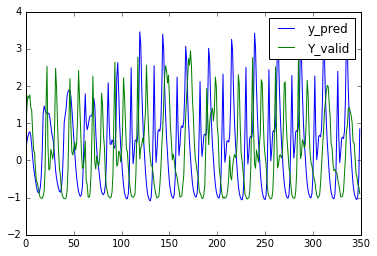

In [23]:
import matplotlib.pyplot as plt

y_pred = net.test(X_seed=X_valid[0], h=net.initial_state(), size=X_valid.shape[0]) # ys_tx1xn
y_pred.shape, Y_valid.shape

plt.plot(y_pred[:350], label='y_pred')
plt.plot(Y_valid[:350], label='Y_valid')
# plt.plot(X_valid[:100], label='X_valid')
plt.legend()
plt.show()